In [1]:
import matplotlib.pyplot as plt
from datetime import datetime, time
from dateutil.relativedelta import relativedelta
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import ta, os, re, warnings
import mplfinance as mpf
from itertools import product
import numpy as np

from tqdm import tqdm

In [2]:
from src.DataUpdateModule import DataUpdateModule
from src.Strategy import Strategy
from src.DayTrade import DayTrade
DUM = DataUpdateModule(options_interval_minutes = 5)
strategy = Strategy()

In [3]:
# Find list of available data
available_data = list()
for x in os.listdir("./data/"):
    date = re.search(r"\d{8}", x).group(0)
    date = datetime(int(date[:4]), int(date[4:6]), int(date[6:]))
    available_data.append(date)
available_data_counts = pd.Series(available_data).value_counts()
available_data = available_data_counts[available_data_counts == 2].index.tolist()

In [4]:
commission_dollars = .15
trading_months = [datetime(2022, 2, 1) + relativedelta(months = x) for x in range(11)]

In [5]:
AUM = 6.5 * 1e6
DAYs = [pd.NA]
MODELs = [pd.NA]
PNLs = [pd.NA]
AUMs = [AUM]

all_actual_trades = list()
trade_summary = list()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for trade_month in trading_months:
        print(f"===== {trade_month} =====")
        # Find best model in past month
        past_month = trade_month - relativedelta(months = 1)
        trade_days = [x for x in available_data if x.year == past_month.year and x.month == past_month.month]

        ## trade
        models_AUM = [AUM] * len(strategy.get_models())
        all_all_trades = list()
        for trade_day in trade_days:
            df_stock, df_options = DUM.read_data(trade_day)
            strategy.compute_tech_indicators(df_stock)
            all_trades = list()
            for model_num in tqdm(range(len(strategy.get_models()))):
                DT = DayTrade(strategy, model_num = model_num, AUM = models_AUM[model_num], df_options = df_options, commission_dollars = commission_dollars, max_risk = 0.025, interval = 5)
                trades = DT.trade()
                models_AUM[model_num] += trades.loc[:, "pnl"].sum() if len(trades) > 0 else 0
                all_trades.append(trades)
            param_pnl = pd.DataFrame([strategy.get_models(x) | {"pnl" : all_trades[x]["pnl"].sum(), "model_num" : x} for x in range(len(all_trades))]).assign(day = trade_day)
            all_all_trades.append(param_pnl)
        all_all_trades = pd.concat(all_all_trades)
        all_all_trades.to_csv(f"./results/past_mth_test_{past_month.strftime('%Y-%m')}.csv")
        ## best model
        ratio = dict()
        for model_num in all_all_trades.loc[:, "model_num"].unique():
            df_plot = all_all_trades[all_all_trades.loc[:, "model_num"] == model_num]
            ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()
        model_rankings = pd.Series(ratio).sort_values(ascending = False)
        model_rankings.to_csv(f"./results/past_mth_test_rankings_{past_month.strftime('%Y-%m')}.csv")
        best_model = model_rankings.index[0]
        print(f"Model selected from {past_month.strftime('%Y-%m')}: {best_model}:{round(model_rankings.iloc[0], 3)}")

        # Actual trading
        trade_days = [x for x in available_data if x.year == trade_month.year and x.month == trade_month.month]

        for trade_day in trade_days:
            # Get information
            df_stock, df_options = DUM.read_data(trade_day)
            strategy.compute_tech_indicators(df_stock)

            # Trade
            DT = DayTrade(strategy, model_num = best_model, AUM = AUMs[-1], df_options = df_options, commission_dollars = commission_dollars, max_risk = 0.025, interval = 5)
            trades = DT.trade()
            pnl = trades.loc[:, "pnl"].sum() if len(trades) > 0 else 0
            AUM = AUMs[-1] + pnl

            # Saving data
            DAYs.append(trade_day)
            MODELs.append(best_model)
            PNLs.append(pnl)
            AUMs.append(AUM)
            all_actual_trades.append(trades)
            trade_summary.append(strategy.get_models(best_model) | {"pnl" : trades.loc[:, "pnl"].sum(), "model_num" : best_model, "day" : trade_day})

            # Print
            print(f"{trade_day.strftime('%Y-%m-%d')} : AUM = {format(round(AUM), ",")}")

    trade_summary = pd.DataFrame(trade_summary)
    trade_summary.to_csv(f"./results/trade_summary")
    all_actual_trades = pd.concat(all_actual_trades)
    all_actual_trades.to_csv(f"./results/trading_mth_test_{trade_month.strftime('%Y-%m')}.csv")

===== 2022-02-01 00:00:00 =====


100%|██████████| 432/432 [00:43<00:00,  9.89it/s]


Model selected from 2022-01: 390:0.541
2022-02-04 : AUM = 6,499,541
2022-02-11 : AUM = 6,481,221
2022-02-18 : AUM = 6,478,465
2022-02-25 : AUM = 6,478,460
===== 2022-03-01 00:00:00 =====


100%|██████████| 432/432 [00:45<00:00,  9.47it/s]


Model selected from 2022-02: 86:4.64
2022-03-04 : AUM = 6,515,310
2022-03-11 : AUM = 6,559,433
2022-03-18 : AUM = 6,538,190
2022-03-25 : AUM = 6,548,943
===== 2022-04-01 00:00:00 =====


100%|██████████| 432/432 [00:44<00:00,  9.80it/s]


Model selected from 2022-03: 143:6.678
2022-04-01 : AUM = 6,559,774
2022-04-08 : AUM = 6,548,030
2022-04-22 : AUM = 6,540,028
2022-04-29 : AUM = 6,498,342
===== 2022-05-01 00:00:00 =====


100%|██████████| 432/432 [00:43<00:00, 10.02it/s]


Model selected from 2022-04: 231:3.481
2022-05-06 : AUM = 6,482,852
2022-05-13 : AUM = 6,496,570
2022-05-20 : AUM = 6,499,592
2022-05-27 : AUM = 6,499,148
===== 2022-06-01 00:00:00 =====


100%|██████████| 432/432 [00:58<00:00,  7.35it/s]


Model selected from 2022-05: 197:6.774
2022-06-03 : AUM = 6,501,331
2022-06-10 : AUM = 6,513,582
2022-06-17 : AUM = 6,499,241
2022-06-24 : AUM = 6,506,750
===== 2022-07-01 00:00:00 =====


100%|██████████| 432/432 [01:20<00:00,  5.37it/s]


Model selected from 2022-06: 71:1.342
2022-07-01 : AUM = 6,506,738
2022-07-08 : AUM = 6,509,149
2022-07-15 : AUM = 6,507,276
2022-07-22 : AUM = 6,507,127
2022-07-29 : AUM = 6,497,712
===== 2022-08-01 00:00:00 =====


100%|██████████| 432/432 [00:49<00:00,  8.76it/s]


Model selected from 2022-07: 407:1.366
2022-08-05 : AUM = 6,498,244
2022-08-12 : AUM = 6,549,707
2022-08-19 : AUM = 6,503,205
2022-08-26 : AUM = 6,562,241
===== 2022-09-01 00:00:00 =====


100%|██████████| 432/432 [00:53<00:00,  8.14it/s]


Model selected from 2022-08: 190:2.777
2022-09-02 : AUM = 6,554,775
2022-09-09 : AUM = 6,603,661
2022-09-16 : AUM = 6,630,248
2022-09-23 : AUM = 6,695,608
2022-09-30 : AUM = 6,627,164
===== 2022-10-01 00:00:00 =====


100%|██████████| 432/432 [00:47<00:00,  9.11it/s]


Model selected from 2022-09: 329:4.319
2022-10-07 : AUM = 6,671,298
2022-10-14 : AUM = 6,718,743
2022-10-21 : AUM = 6,752,255
2022-10-28 : AUM = 6,848,595
===== 2022-11-01 00:00:00 =====


100%|██████████| 432/432 [00:37<00:00, 11.37it/s]


Model selected from 2022-10: 270:6.78
2022-11-04 : AUM = 6,855,010
2022-11-11 : AUM = 6,856,665
2022-11-18 : AUM = 6,918,580
2022-11-25 : AUM = 6,972,473
===== 2022-12-01 00:00:00 =====


100%|██████████| 432/432 [00:27<00:00, 15.74it/s]


Model selected from 2022-11: 112:1.374
2022-12-02 : AUM = 6,886,402
2022-12-09 : AUM = 6,906,875
2022-12-16 : AUM = 6,878,568
2022-12-23 : AUM = 6,865,396
2022-12-30 : AUM = 6,917,400


(-5.0, 10.0)

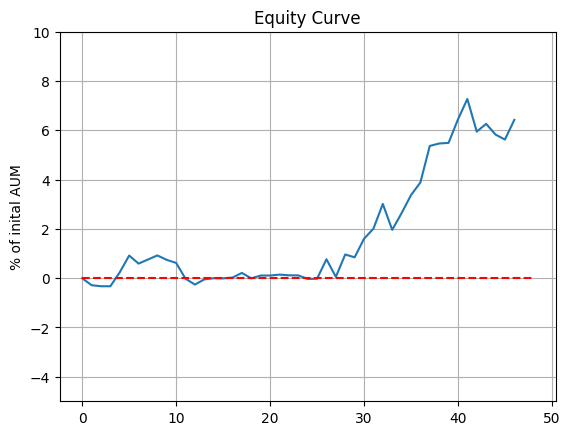

In [15]:
plt.title("Equity Curve")
plt.grid()
plt.plot(pd.Series(PNLs).dropna().cumsum().values.astype(float) / (6.5 * 1e6) * 100)
plt.hlines(y = 0, xmin = 0, xmax = len(PNLs), linestyle = "--", color = "red")
plt.ylabel("% of inital AUM")
plt.ylim(-5, 10)

In [7]:
aa = pd.concat([pd.read_csv(f"./results/past_mth_test_{datetime(2022, m, 1).strftime('%Y-%m')}.csv").drop(columns = ["Unnamed: 0"]) for m in range(1, 12)])

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

X = aa.drop(columns = ["pnl", "model_num", "day"])
y = aa.loc[:, "pnl"]

RFR = RandomForestRegressor(n_estimators = 100, random_state = 408).fit(X, y)

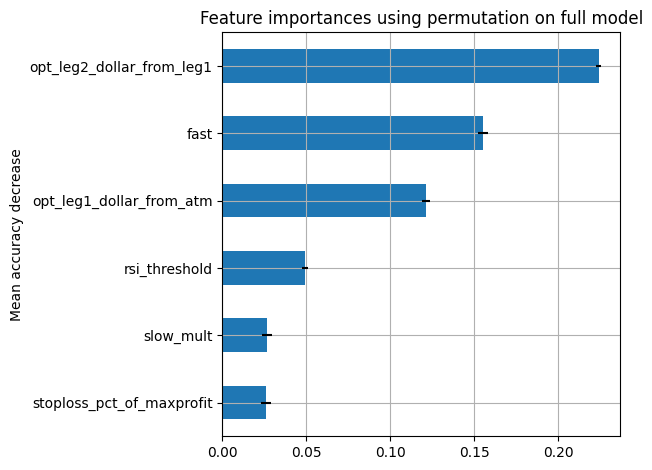

In [9]:
pi = permutation_importance(RFR, X, y, n_repeats=10, random_state=42, n_jobs=-1)
forest_importances = pd.Series(pi.importances_mean, index=X.columns).sort_values()

fig, ax = plt.subplots()
forest_importances.plot.barh(xerr=pi.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
ax.grid()
fig.tight_layout()
plt.show()

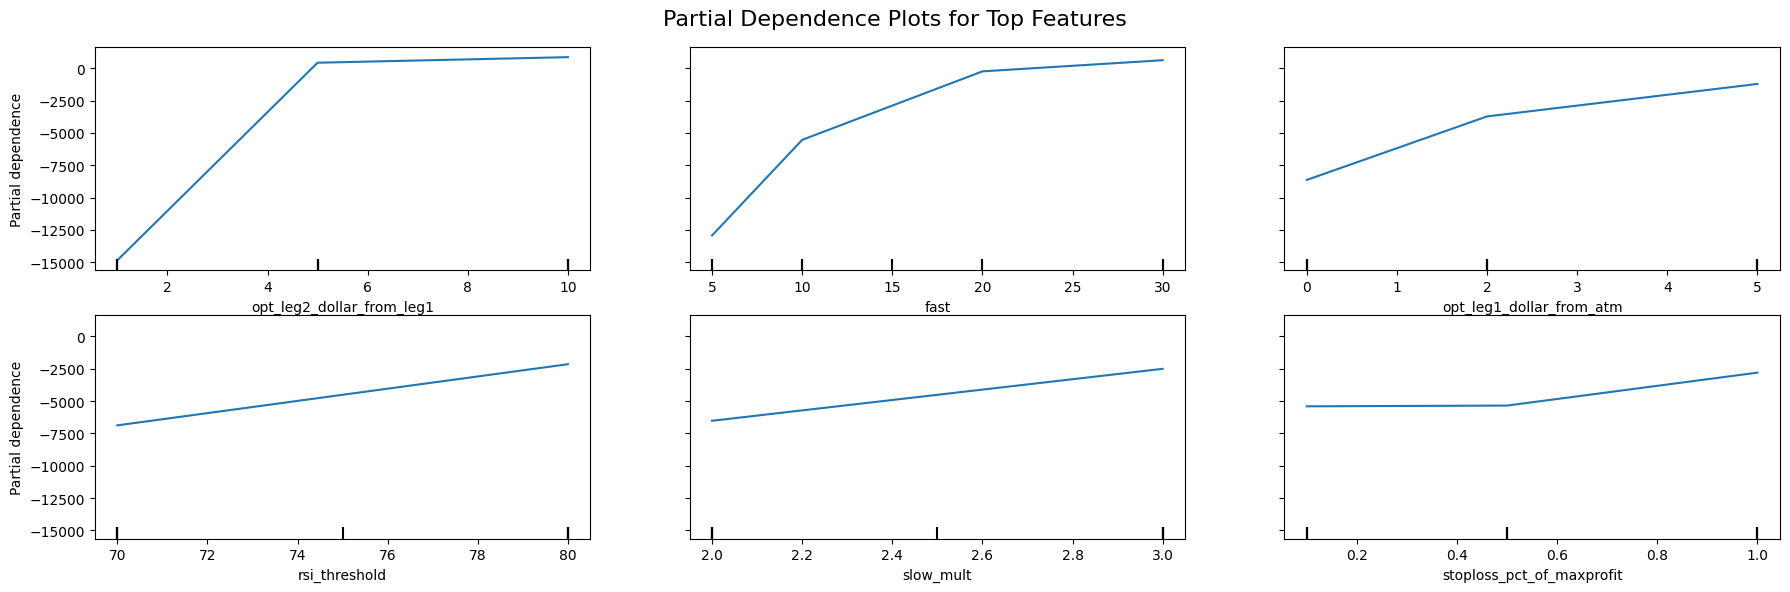

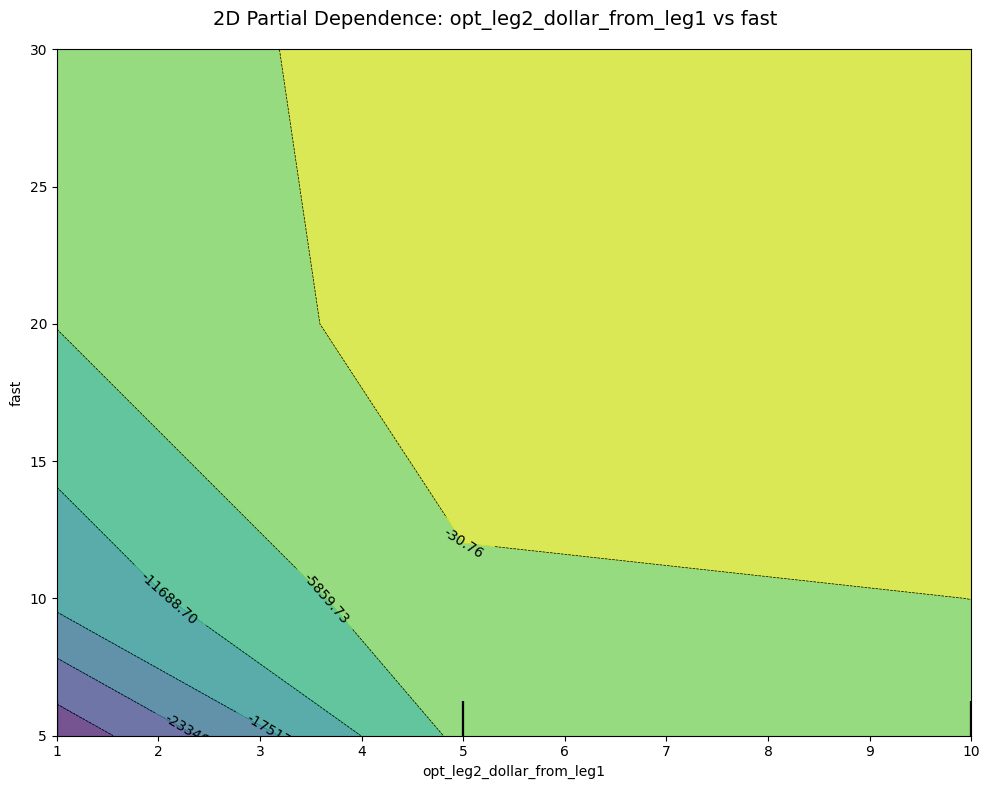

In [11]:
from sklearn.inspection import PartialDependenceDisplay

forest_importances = pd.Series(pi.importances_mean, index=X.columns).sort_values(ascending=False)

# Select top N features (e.g., top 4-6 features)
top_n = 6
top_features = forest_importances.head(top_n).index.tolist()

# Generate partial dependence plots for top features
fig, ax = plt.subplots(figsize=(18, 6))
PartialDependenceDisplay.from_estimator(
    RFR,
    X,
    features=top_features,
    kind="average",  # or "individual" for ICE plots, or "both"
    grid_resolution=50,
    n_jobs=-1,
    ax=ax,
)
plt.suptitle("Partial Dependence Plots for Top Features", fontsize=16)
plt.tight_layout()
plt.show()

# Alternative: Create 2D partial dependence plot for feature interactions
# Select top 2 features for interaction plot
if len(top_features) >= 2:
    fig, ax = plt.subplots(figsize=(10, 8))
    PartialDependenceDisplay.from_estimator(
        RFR,
        X,
        features=[(top_features[0], top_features[1])],  # Feature pair
        kind="average",
        grid_resolution=20,
        n_jobs=-1,
        ax=ax
    )
    plt.suptitle(f"2D Partial Dependence: {top_features[0]} vs {top_features[1]}", fontsize=14)
    plt.tight_layout()
    plt.show()